# This is a notebook intended to evaluate the typical difference between a RA, DEC -> Pixel transformation for the TESS satellite with & without a GCRS velocity abberation correction

We will use the Sector/Camera/CCD footprint files that we're using to test tesspoint to compare values with & without the -a aberration correction

In [594]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import subprocess
import multiprocessing
from itertools import product

import matplotlib.pyplot as plt
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.coordinates import Angle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### To do this, we will:
    - Grab the footprints in RA, Dec coordinates that we're using to test tesspoint
        - using my local repo here, these *should* be the same files as:
        - https://github.com/tylerapritchard/TESSPoint_CreateTestFiles/blob/main/TESSPoint_CreateTestFiles.ipynb
    - For each RA, Dec footprint file
        - Calculate the pixel locations assosciated with each RA, Dec using:
            - default tess_stars2px.py
            - tess_stars2px.py *WITH* aberration correction ("-a")
            - calculate absolute pixel offsets (delta row, column) and distance (d=sqrt(dr^2 + dc^2)
    - Iterate across Sector/Camera/CCDs to test all of our footprints
    - Check the values/distributions
    - Validate the aberration correction by commenting out the "-a" which should give all zeros for a test set

In [513]:
def parse_tess_stars2px_out(stdout):
    ''' Parse the command-line output of tess_stars2px.py
    subprocess will give us one massive string that would have been a file
    we'll use split on the endline character to break this up and iterate over lines
    then on each line extract the row and column pixel assosciated with the index/ra/dec 
    and output these as an appended dataframe
    '''
    lines=stdout.split('\n')
    lines=lines[1:] #strip out the header 6,7
    df=pd.DataFrame(data={'tic':[],'col':[],'row':[],'ra':[],'dec':[], 'camera':[], 'ccd':[]})
    for line in lines:
        split=line.split(' | ')
        if len(split) > 1:
            split=np.array(split, dtype=np.double)
            df=pd.concat([df, 
                          pd.DataFrame(data={'tic':split[0],'col':split[8],'row':split[9], 
                                             'ra':split[1], 'dec':split[2], 'camera':split[6], 'ccd':split[7]},
                                       index=[split[0]])])
    return df

def compare_radec2pix(Sector, Camera, CCD):
    '''This will compare our WCS -> Pixel calculation for a single Sector, Camera, CCD against with an 
    abberation correction ("-a") against a benchmark calculation without the correction. The source files are 
    a local copy of https://github.com/tylerapritchard/TESSPoint_CreateTestFiles
    calculates distance in pixels between the rows & colums
    '''

    footprint_loc="/Users/tapritc2/tessgi/tesspoint/TESSPoint_CreateTestFiles/testfiles/TEST_pix2radec_Sec{:02d}_Cam{}_CCD{}_stars2px.dat".format(Sector,Camera,CCD)
    
    #validate this, commenting out -a to so we should have zero offset
    point_abr=subprocess.run(["python","/Users/tapritc2/tessgi/tesspoint/tess-point/tess_stars2px.py",
                        "-s",str(Sector),"-a","-f",footprint_loc],capture_output=True,text=True)

    point_noabr=subprocess.run(["python","/Users/tapritc2/tessgi/tesspoint/tess-point/tess_stars2px.py",
                        "-s",str(Sector),"-f",footprint_loc],capture_output=True,text=True)

    point_abr_df=parse_tess_stars2px_out(point_abr.stdout)
    point_noabr_df=parse_tess_stars2px_out(point_noabr.stdout)
    
    # make sure we're only grabbing targets in the right camera, there is overlap & we can only specify sector
    camcut = point_abr_df.camera == Camera
    point_abr_df=point_abr_df[camcut]
    ccdcut = point_abr_df.ccd == CCD
    point_abr_df=point_abr_df[ccdcut]
    
    camcut = point_noabr_df.camera == Camera
    point_noabr_df=point_noabr_df[camcut]
    ccdcut = point_noabr_df.ccd == CCD
    point_noabr_df=point_noabr_df[ccdcut]
    
    idx = point_abr_df.index.intersection(point_noabr_df.index)
    idx2= point_noabr_df.index.intersection(point_abr_df.index)
    point_abr_df=point_abr_df.loc[idx]
    point_noabr_df=point_noabr_df.loc[idx2]
    
    d_col = abs(point_abr_df.col - point_noabr_df.col)
    d_row = abs(point_abr_df.row - point_noabr_df.row)
    dist=np.hypot(d_col, d_row)

    ra=point_noabr_df.ra.values
    dec=point_noabr_df.dec.values

    #print(f"len {point_abr_df.tic[idx]} {point_noabr_df.tic[idx2]}")
    #print(f"lengths: idx: {len(idx)} idx2: {len(idx2)} ra: {len(ra)} dec: {len(dec)} dist: {len(dist)} dcol:{len(d_col)} drow:{len(d_row)} col:{len(point_noabr_df.col)} row:{len(point_noabr_df.row)} acol:{len(point_abr_df.col)} arow:{len(point_abr_df.row)}")
    return d_col.values, d_row.values, dist, point_abr_df.col.values, point_abr_df.row.values, point_noabr_df.col.values, point_noabr_df.row.values,ra, dec

def test_radec2pix(sector_list, camera_list, ccd_list):
    '''this will test the pixel->WCS calculation for all Sector / Camera / CCD's 
    with an aberration correction and without'''
    results_df = pd.DataFrame(data={'dcol':[],'drow':[],'dist':[],'row':[],'col':[],'arow':[],'acol':[] ,
                                    'sector':[],'camera':[],'ccd':[],'ra':[], 'dec':[]})

    for sector in sector_list:
        for camera in camera_list:
            for ccd in ccd_list:
                dcol, drow, dist, acol, arow, col, row, ra, dec = compare_radec2pix(sector, camera, ccd)
                results_df=pd.concat([results_df, 
                          pd.DataFrame(data={'dcol':dcol,'drow':drow,'dist':dist,
                                             'row':row, 'col':col, 'arow':arow,'acol':acol,
                                            'sector':[sector] * len(dcol),
                                             'camera':[camera] * len(dcol),
                                             'ccd':[ccd] * len(dcol), 
                                            'ra': ra, 'dec': dec})], ignore_index=True)
    return results_df


In [515]:
abr_comp_df=test_radec2pix(range(1,69),range(1,5),range(1,5))

In [516]:
# This took ~1hr to run, saving below
# if this is ever to be re-run or integrated as a test consider pool multiprocessing
# just a pain to to mid-notebook

#abr_comp_df.to_csv('abrcomp_v2.csv')

In [517]:
abr_comp_df

,dcol,drow,dist,row,col,arow,acol,sector,camera,ccd,ra,dec
0,1.032816,0.015447,1.032932,0.5,292.928571,0.515447,293.961387,1.0,1.0,1.0,316.040399,-47.573501
1,1.017850,0.010053,1.017900,0.5,585.357143,0.510053,586.374993,1.0,1.0,1.0,318.311101,-47.221717
2,1.006169,0.005280,1.006183,0.5,877.785714,0.505280,878.791883,1.0,1.0,1.0,320.585809,-46.810995
3,0.997424,0.001023,0.997425,0.5,1170.214286,0.501023,1171.211710,1.0,1.0,1.0,322.852003,-46.342623
4,0.991324,0.002854,0.991328,0.5,1462.642857,0.497146,1463.634181,1.0,1.0,1.0,325.098034,-45.818602
...,...,...,...,...,...,...,...,...,...,...,...,...
84715,0.956740,0.000633,0.956740,1920.0,486.400000,1919.999367,487.356740,68.0,4.0,4.0,88.921457,-61.969954
84716,0.962183,0.000980,0.962183,1920.0,844.800000,1919.999020,845.762183,68.0,4.0,4.0,86.190404,-60.346049
84717,0.970895,0.001345,0.970896,1920.0,1203.200000,1919.998655,1204.170895,68.0,4.0,4.0,83.746868,-58.690639
84718,0.983144,0.001749,0.983146,1920.0,1561.600000,1919.998251,1562.583144,68.0,4.0,4.0,81.559503,-57.020423


## Results: 
 - The average pixel offset is ~ 1 pixel in cartesian distance.  
 - Most of that is from column offsets, with most row offsets being low.  
 - There seems to be a natural cutoff at ~1.1 in distance.  

Median / Minimum / Maximum Column Offset:  0.9955595000000699 / 1.1999999969702912e-05 / 1.087355000000116
Median / Minimum / Maximum Row Offset:     0.01660699999998122 / 1.0000001111620804e-06 / 1.085557
Median / Minimum / Maximum Distance Offset:0.9962144501325036 / 0.005600333204419896 / 1.090022240868966
stddev Column / Row / Distance 0.23980416918384678 / 0.16554206458844825 / 0.13840593010219934


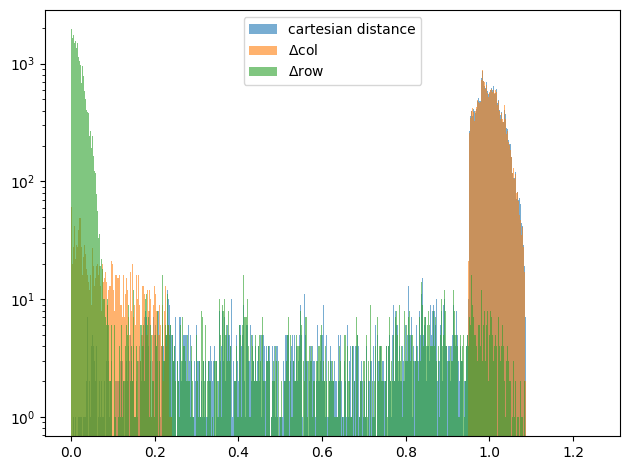

In [518]:
print(f"Median / Minimum / Maximum Column Offset:  {np.median(abr_comp_df.dcol.values)} / {min(abr_comp_df.dcol.values)} / {max(abr_comp_df.dcol.values)}")
print(f"Median / Minimum / Maximum Row Offset:     {np.median(abr_comp_df.drow.values)} / {min(abr_comp_df.drow.values)} / {max(abr_comp_df.drow.values)}")
print(f"Median / Minimum / Maximum Distance Offset:{np.median(abr_comp_df.dist.values)} / {min(abr_comp_df.dist.values)} / {max(abr_comp_df.dist.values)}")
print(f"stddev Column / Row / Distance {np.std(abr_comp_df.dcol.values)} / {np.std(abr_comp_df.drow.values)} / {np.std(abr_comp_df.dist.values)}")
fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)
ax.hist(abr_comp_df.dist.values,bins=2000,range=[0,1.25],log=True,label='cartesian distance',alpha=0.6)
ax.hist(abr_comp_df.dcol.values,bins=2000,range=[0,1.25],log=True,label='$\Delta$col',alpha=0.6)
ax.hist(abr_comp_df.drow.values,bins=2000,range=[0,1.25],log=True,label='$\Delta$row',alpha=0.6)
plt.legend()


# There are no more targets with unphysically large differences in position due to the aberration correction - things are now "well behaved"

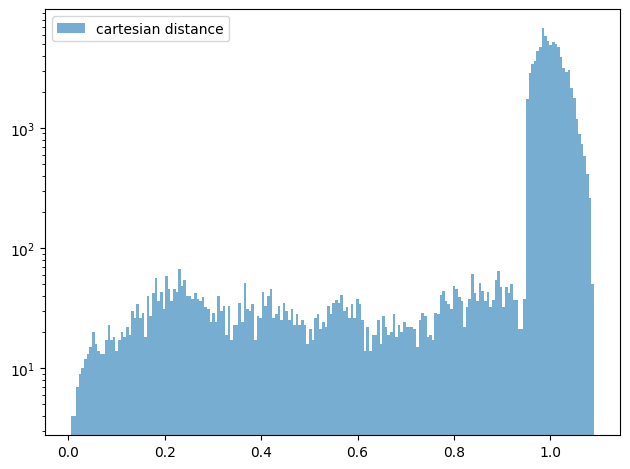

In [519]:
fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)
ax.hist(abr_comp_df.dist.values,bins=200,log=True,label='cartesian distance',alpha=0.6)
plt.legend()

# No More Outliers!!!

In [520]:
count=sum(1 for i in abr_comp_df.dist.values if i > 1.25)
print(f"N(outliers)={count}, fractional calue = {count/len(abr_comp_df.dist.values)}")

N(outliers)=0, fractional calue = 0.0


# Lets do an icrs-> gcrs conversion and check the difference in RA, DEC -> these should be ~ 20" aka one pixel if this math is all correct

In [571]:
midtimes = np.array([ 2458339.652778, 2458368.593750, 2458396.659722, 2458424.548611, 2458451.548611, \
                 2458478.104167, 2458504.697917, 2458530.256944, 2458556.722222, \
                 2458582.760417, 2458610.774306, 2458640.031250, 2458668.618056, \
                 2458697.336806, 2458724.934028, 2458751.649306, 2458777.722222, \
                 2458803.440972, 2458828.958333, 2458856.388889, 2458884.916667, 2458913.565972, \
                 2458941.829861, 2458969.263889, 2458996.909722, 2459023.107639, \
                 2459049.145833, 2459075.166667, 2459102.319444, 2459130.201389, \
                 2459158.854167, 2459186.940972, 2459215.427083, 2459241.979167, \
                 2459268.579861, 2459295.301177, 2459322.577780, 2459349.854382, \
                 2459377.130985, \
                 2459404.407588, 2459431.684191, 2459458.960794, 2459486.237397, \
                 2459513.514000, 2459540.790602, 2459568.067205, 2459595.343808, \
                 2459622.620411, 2459649.897014, 2459677.173617, 2459704.450219, \
                 2459731.726822, 2459759.003425, 2459786.280028, 2459813.556631, \
                 2459840.833234, 2459868.109837, 2459895.386439, 2459922.663042, \
                 2459949.939645, 2459977.216248, 2460004.492851, 2460031.769454, \
                 2460059.046057, 2460086.322659, 2460113.599262, 2460140.875865, \
                 2460168.152468, 2460195.429071,\
                 2460220.5, 2460246.5, 2460272.5,\
                 2460299 , 2460326 , 2460353 , 2460381 ,\
                 2460409.5, 2460437.5, 2460465.5, 2460493 ,\
                 2460519.5, 2460545.5, 2460571.5], dtype=float)

def convert_icrs_gcrs(ras,decs, midtimes):
    # first lets add midtimes to our dtaframe
    ccat = SkyCoord(
            ra=ras * u.deg,
            dec=decs * u.deg,
            obstime=midtimes,
            frame="icrs",
        )
        ## convert to Geocentric aberrated coordinates
        ## This is only an approximation to TESS
        ##  because TESS orbits Earth and has
        #  velocity <=4km/s relative to Earth whereas Earth is 30km/s
    cgcrs = ccat.transform_to("gcrs")

    return cgcrs, ccat


In [630]:
mids=Time([midtimes[int(sector) - 1] for sector in abr_comp_df.sector.values], format="jd")
cgcrs, ccat = convert_icrs_gcrs(abr_comp_df.ra.values, abr_comp_df.dec.values, mids)
print(max(abs(ccat.ra.deg - abr_comp_df.ra.values)))
print(max(abs(ccat.dec.deg - abr_comp_df.dec.values)))

0.0
0.0


In [631]:
wcs_sep=cgcrs.separation(ccat)
print(wcs_sep)
# This is giving us zeroes - is that because its keeping track if the frame?

[0d00m00s 0d00m00s 0d00m00s ... 0d00m00s 0d00m00s 0d00m00s]


In [632]:
# Probably
print(cgcrs[0].ra - ccat[0].ra)
print(cgcrs[0].dec - ccat[0].dec)

0d00m28.6633504s
0d00m04.37731665s


In [645]:
wcs_sep=ccat_gc.separation(ccat)
wcs_sep
print(max(wcs_sep))

0d00m20.84126091s


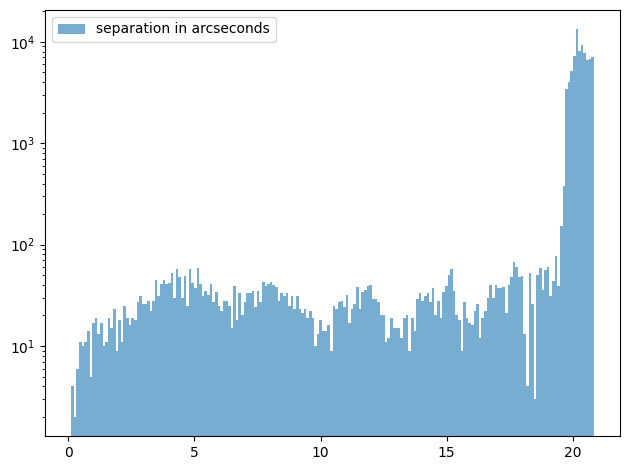

In [648]:
fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)
ax.hist(wcs_sep.arcsecond,bins=200,log=True,label='separation in arcseconds',alpha=0.6)

plt.legend()

# Things seem to be well behaved now - lower cells are legacy debugging in case we want to re-check something

### lets look for a comparison against Sector/Camera/CCD to see if there are any strong correlations with those properties

In [636]:
#This is wrong - something about coordinate wrapping here probably?
wcs_dist=np.hypot(abs((cgcrs.ra - ccat.ra).arcsecond),abs((cgcrs.dec - ccat.dec).arcsecond))
print(max((cgcrs.ra - ccat.ra)))


1d12m13.95057482s


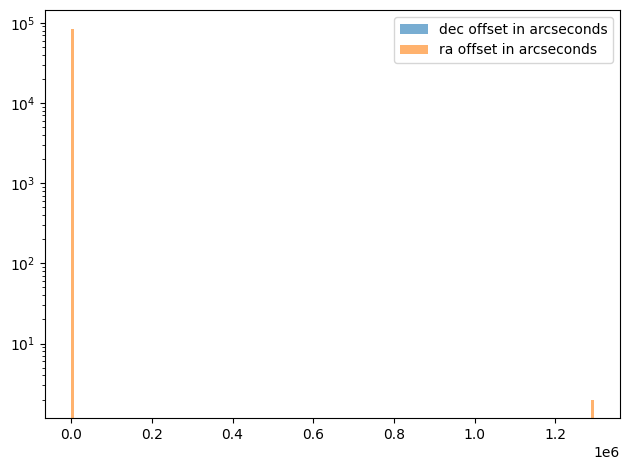

In [634]:
# seems way wrong
#cut =  wcs_dist <2e2

fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)
#ax.hist(wcs_dist[cut],bins=200,log=True,label='offset in arcseconds',alpha=0.6)
ax.hist(abs((cgcrs.dec - ccat.dec).arcsec),bins=200,log=True,label='dec offset in arcseconds',alpha=0.6)
ax.hist(abs((cgcrs.ra - ccat.ra).arcsec),bins=200,log=True,label='ra offset in arcseconds',alpha=0.6)

plt.legend()


In [642]:
# Lets fudge this - new ICRS frame with the GCRS RA, DEC
ccat_gc =  SkyCoord(
            ra= cgcrs.ra.degree * u.deg,
            dec=cgcrs.dec.degree * u.deg,
            obstime=mids,
            frame="icrs",
        )

In [521]:
abr_comp_df.keys()
cut =  abr_comp_df.dist > 1.25
abr_comp_df.loc[cut,'camera']
print()

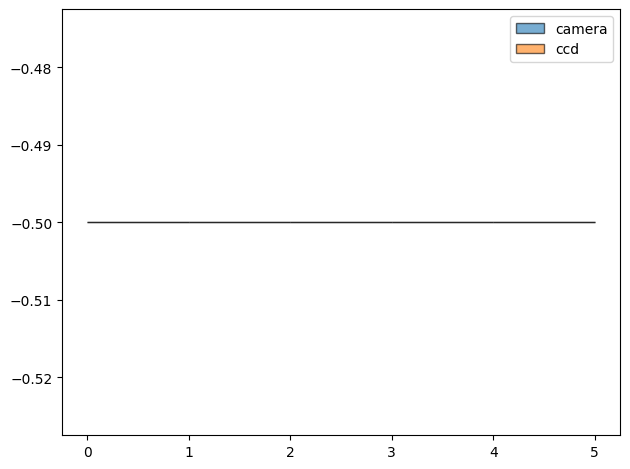

In [522]:
cut =  abr_comp_df.dist > 1.25
fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)
ax.hist(abr_comp_df.loc[cut,'camera'],bins=[0,1,2,3,4,5],bottom=-0.5,label='camera',alpha=0.6, ec='black')
ax.hist(abr_comp_df.loc[cut,'ccd']   ,bins=[0,1,2,3,4,5],bottom=-0.5,label='ccd',alpha=0.6, ec='black')
plt.legend()

ValueError: min() arg is an empty sequence

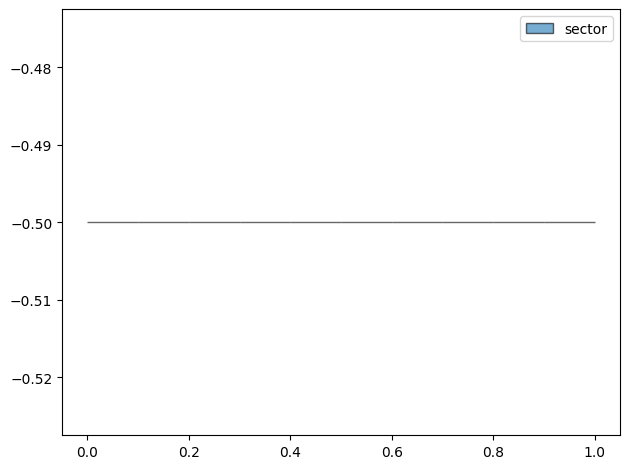

In [525]:
cut =  abr_comp_df.dist > 1.25
fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)
ax.hist(abr_comp_df.loc[cut,'sector'],bottom=-0.5,label='sector',alpha=0.6, ec='black')
plt.legend()
print(f"Minimum Sector: {min(abr_comp_df.loc[cut,'sector'].values)}")
print(f"Maximum Sector: {max(abr_comp_df.loc[cut,'sector'].values)}")

# Commented out the "-a" abberation correction in the test_radec2pix_AllCameraSectorCCD function
This should then perform the same calculation twice and measure the distance between identical values, and se return all zeros
This is confirmed, test of functions seems to be working

In [256]:
#Commented out the -a aberration correction, should be zeros
#abr_validation_df=test_radec2pix_AllCameraSectorCCD()
print(f"Median / Minimum / Maximum Column Offset:  {np.median(abr_validation_df.dcol.values)} / {min(abr_validation_df.dcol.values)} / {max(abr_validation_df.dcol.values)}")
print(f"Median / Minimum / Maximum Row Offset:     {np.median(abr_validation_df.drow.values)} / {min(abr_validation_df.drow.values)} / {max(abr_validation_df.drow.values)}")
print(f"Median / Minimum / Maximum Distance Offset:{np.median(abr_validation_df.dist.values)} / {min(abr_validation_df.dist.values)} / {max(abr_validation_df.dist.values)}")
print(f"stddev Column / Row / Distance {np.std(abr_validation_df.dcol.values)} / {np.std(abr_validation_df.drow.values)} / {np.std(abr_validation_df.dist.values)}")
abr_validation_df
#THIS LOOKS GOOD!

Median / Minimum / Maximum Column Offset:  0.0 / 0.0 / 0.0
Median / Minimum / Maximum Row Offset:     0.0 / 0.0 / 0.0
Median / Minimum / Maximum Distance Offset:0.0 / 0.0 / 0.0
stddev Column / Row / Distance 0.0 / 0.0 / 0.0


,dcol,drow,dist,sector,camera,ccd
0,0.0,0.0,0.0,1.0,1.0,1.0
1,0.0,0.0,0.0,1.0,1.0,1.0
2,0.0,0.0,0.0,1.0,1.0,1.0
3,0.0,0.0,0.0,1.0,1.0,1.0
4,0.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...
3970,0.0,0.0,0.0,3.0,4.0,4.0
3971,0.0,0.0,0.0,3.0,4.0,4.0
3972,0.0,0.0,0.0,3.0,4.0,4.0
3973,0.0,0.0,0.0,3.0,4.0,4.0


In [503]:
def parse_tess_stars2px_out(stdout):
    ''' Parse the command-line output of tess_stars2px.py
    subprocess will give us one massive string that would have been a file
    we'll use split on the endline character to break this up and iterate over lines
    then on each line extract the row and column pixel assosciated with the index/ra/dec 
    and output these as an appended dataframe
    '''
    lines=stdout.split('\n')
    lines=lines[1:] #strip out the header 6,7
    df=pd.DataFrame(data={'tic':[],'col':[],'row':[],'ra':[],'dec':[], 'camera':[], 'ccd':[]})
    for line in lines:
        split=line.split(' | ')
        if len(split) > 1:
            split=np.array(split, dtype=np.double)
            df=pd.concat([df, 
                          pd.DataFrame(data={'tic':split[0],'col':split[8],'row':split[9], 
                                             'ra':split[1], 'dec':split[2], 'camera':split[6], 'ccd':split[7]},
                                       index=[split[0]])])
    return df

def compare_radec2pix(Sector, Camera, CCD):
    '''This will compare our WCS -> Pixel calculation for a single Sector, Camera, CCD against with an 
    abberation correction ("-a") against a benchmark calculation without the correction. The source files are 
    a local copy of https://github.com/tylerapritchard/TESSPoint_CreateTestFiles
    calculates distance in pixels between the rows & colums
    '''

    footprint_loc="/Users/tapritc2/tessgi/tesspoint/TESSPoint_CreateTestFiles/testfiles/TEST_pix2radec_Sec{:02d}_Cam{}_CCD{}_stars2px.dat".format(Sector,Camera,CCD)
    
    #validate this, commenting out -a to so we should have zero offset
    point_abr=subprocess.run(["python","/Users/tapritc2/tessgi/tesspoint/tess-point/tess_stars2px.py",
                        "-s",str(Sector),"-a","-f",footprint_loc],capture_output=True,text=True)

    point_noabr=subprocess.run(["python","/Users/tapritc2/tessgi/tesspoint/tess-point/tess_stars2px.py",
                        "-s",str(Sector),"-f",footprint_loc],capture_output=True,text=True)

    point_abr_df=parse_tess_stars2px_out(point_abr.stdout)
    point_noabr_df=parse_tess_stars2px_out(point_noabr.stdout)
    
    # make sure we're only grabbing targets in the right camera, there is overlap & we can only specify sector
    camcut = point_abr_df.camera == Camera
    point_abr_df=point_abr_df[camcut]
    ccdcut = point_abr_df.ccd == CCD
    point_abr_df=point_abr_df[ccdcut]
    
    camcut = point_noabr_df.camera == Camera
    point_noabr_df=point_noabr_df[camcut]
    ccdcut = point_noabr_df.ccd == CCD
    point_noabr_df=point_noabr_df[ccdcut]
    
    idx = point_abr_df.index.intersection(point_noabr_df.index)
    idx2= point_noabr_df.index.intersection(point_abr_df.index)
    point_abr_df=point_abr_df.loc[idx]
    point_noabr_df=point_noabr_df.loc[idx2]
    
    d_col = abs(point_abr_df.col - point_noabr_df.col)
    d_row = abs(point_abr_df.row - point_noabr_df.row)
    dist=np.hypot(d_col, d_row)

    ra=point_noabr_df.ra.values
    dec=point_noabr_df.dec.values

    #print(f"len {point_abr_df.tic[idx]} {point_noabr_df.tic[idx2]}")
    #print(f"lengths: idx: {len(idx)} idx2: {len(idx2)} ra: {len(ra)} dec: {len(dec)} dist: {len(dist)} dcol:{len(d_col)} drow:{len(d_row)} col:{len(point_noabr_df.col)} row:{len(point_noabr_df.row)} acol:{len(point_abr_df.col)} arow:{len(point_abr_df.row)}")
    return d_col.values, d_row.values, dist, point_abr_df.col.values, point_abr_df.row.values, point_noabr_df.col.values, point_noabr_df.row.values,ra, dec

def test_radec2pix(sector_list, camera_list, ccd_list):
    '''this will test the pixel->WCS calculation for all Sector / Camera / CCD's 
    with an aberration correction and without'''
    results_df = pd.DataFrame(data={'dcol':[],'drow':[],'dist':[],'row':[],'col':[],'arow':[],'acol':[] ,
                                    'sector':[],'camera':[],'ccd':[],'ra':[], 'dec':[]})

    for sector in sector_list:
        for camera in camera_list:
            for ccd in ccd_list:
                dcol, drow, dist, acol, arow, col, row, ra, dec = compare_radec2pix(sector, camera, ccd)
                results_df=pd.concat([results_df, 
                          pd.DataFrame(data={'dcol':dcol,'drow':drow,'dist':dist,
                                             'row':row, 'col':col, 'arow':arow,'acol':acol,
                                            'sector':[sector] * len(dcol),
                                             'camera':[camera] * len(dcol),
                                             'ccd':[ccd] * len(dcol), 
                                            'ra': ra, 'dec': dec})], ignore_index=True)
    return results_df


In [482]:
Sector = 42
Camera = 1
CCD = 1
result= compare_radec2pix(1,1,1)
result= compare_radec2pix(42,1,1)

lengths: idx: 78 idx2: 78 ra: 78 dec: 78 dist: 78 dcol:78 drow:78 col:78 row:78 acol:78 arow:78
lengths: idx: 70 idx2: 70 ra: 70 dec: 70 dist: 70 dcol:70 drow:70 col:70 row:70 acol:70 arow:70


In [483]:
Sector = 1
Camera = 1
CCD = 1
footprint_loc="/Users/tapritc2/tessgi/tesspoint/TESSPoint_CreateTestFiles/testfiles/TEST_pix2radec_Sec{:02d}_Cam{}_CCD{}_stars2px.dat".format(Sector,Camera,CCD)
point=subprocess.run(["python","/Users/tapritc2/tessgi/tesspoint/tess-point/tess_stars2px.py",
                        "-s",str(Sector),"-a","-f",footprint_loc],capture_output=True,text=True)
parse_tess_stars2px_out(point.stdout)


,tic,col,row,ra,dec,camera,ccd
9.0,9.0,293.961387,0.515447,316.040399,-47.573501,1.0,1.0
10.0,10.0,586.374993,0.510053,318.311101,-47.221717,1.0,1.0
11.0,11.0,878.791883,0.505280,320.585809,-46.810995,1.0,1.0
11.0,11.0,1270.710686,8.338522,320.585809,-46.810995,2.0,4.0
12.0,12.0,1171.211710,0.501023,322.852003,-46.342623,1.0,1.0
...,...,...,...,...,...,...,...
91.0,91.0,487.385609,1919.994151,313.608899,-37.000082,1.0,1.0
92.0,92.0,845.772551,1919.993823,316.060711,-36.500065,1.0,1.0
93.0,93.0,1204.163111,1919.993526,318.520194,-35.940030,1.0,1.0
94.0,94.0,1562.556923,1919.993230,320.972906,-35.322063,1.0,1.0


In [526]:
tests1 = test_radec2pix(range(1,2),range(1,5),range(1,5))

In [527]:
tests1

,dcol,drow,dist,row,col,arow,acol,sector,camera,ccd,ra,dec
0,1.032816,0.015447,1.032932,0.5,292.928571,0.515447,293.961387,1.0,1.0,1.0,316.040399,-47.573501
1,1.017850,0.010053,1.017900,0.5,585.357143,0.510053,586.374993,1.0,1.0,1.0,318.311101,-47.221717
2,1.006169,0.005280,1.006183,0.5,877.785714,0.505280,878.791883,1.0,1.0,1.0,320.585809,-46.810995
3,0.997424,0.001023,0.997425,0.5,1170.214286,0.501023,1171.211710,1.0,1.0,1.0,322.852003,-46.342623
4,0.991324,0.002854,0.991328,0.5,1462.642857,0.497146,1463.634181,1.0,1.0,1.0,325.098034,-45.818602
...,...,...,...,...,...,...,...,...,...,...,...,...
1243,0.957340,0.017413,0.957498,1920.0,486.400000,1919.982587,487.357340,1.0,4.0,4.0,87.204662,-63.641619
1244,0.963317,0.017823,0.963482,1920.0,844.800000,1919.982177,845.763317,1.0,4.0,4.0,84.234419,-62.049333
1245,0.972574,0.018285,0.972746,1920.0,1203.200000,1919.981715,1204.172574,1.0,4.0,4.0,81.591493,-60.418583
1246,0.985383,0.018820,0.985563,1920.0,1561.600000,1919.981180,1562.585383,1.0,4.0,4.0,79.238640,-58.767511


In [528]:
print(max(tests1.dist.values))

1.054863217531479


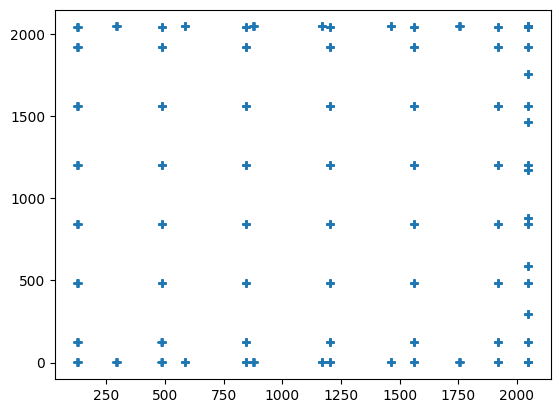

In [529]:
plt.plot(tests1.acol.values, tests1.arow.values,linestyle='None',marker='+')

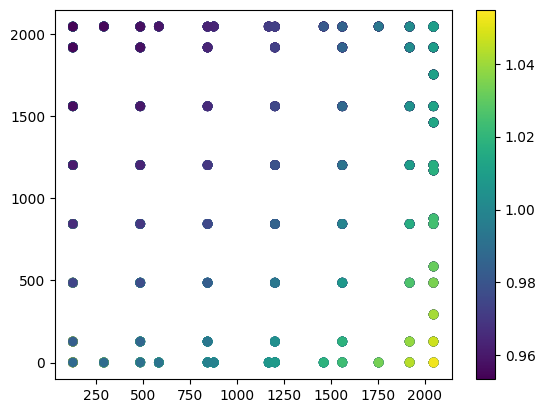

In [530]:

plt.scatter(tests1.col.values, tests1.row.values,c=tests1.dist.values)
plt.colorbar()

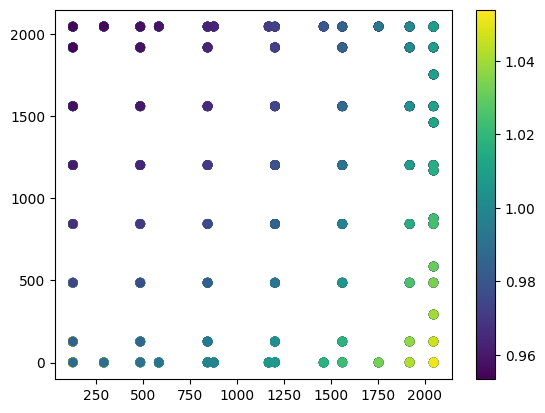

In [531]:
plt.scatter(tests1.col.values, tests1.row.values,c=tests1.dcol.values)
plt.colorbar()

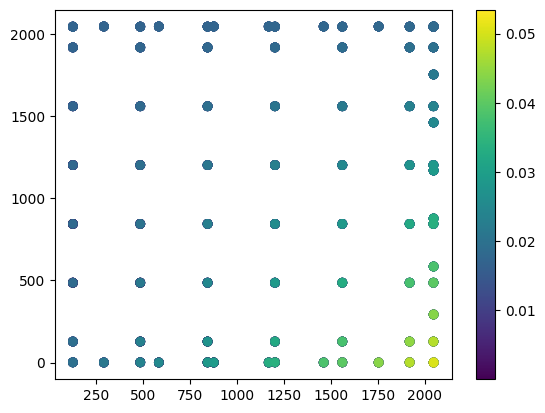

In [532]:
plt.scatter(tests1.col.values, tests1.row.values,c=tests1.drow.values)
plt.colorbar()

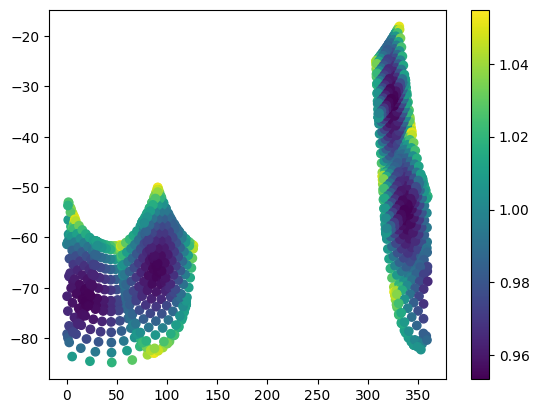

In [533]:
plt.scatter(tests1.ra.values, tests1.dec.values,c=tests1.dist.values)
plt.colorbar()

In [534]:
test_ecl = test_radec2pix(range(42,47),range(1,5),range(1,5))

In [535]:
test_ecl

,dcol,drow,dist,row,col,arow,acol,sector,camera,ccd,ra,dec
0,0.013841,0.983141,0.983238,2047.5,292.928571,2046.516859,292.914730,42.0,1.0,1.0,344.441039,-17.679058
1,0.012889,0.975683,0.975768,2047.5,585.357143,2046.524317,585.344254,42.0,1.0,1.0,343.765745,-16.179593
2,0.011998,0.969513,0.969587,2047.5,877.785714,2046.530487,877.773716,42.0,1.0,1.0,343.089353,-14.652787
3,0.011152,0.964607,0.964671,2047.5,1170.214285,2046.535393,1170.203133,42.0,1.0,1.0,342.413224,-13.103436
4,0.010342,0.960960,0.961016,2047.5,1462.642857,2046.539040,1462.632515,42.0,1.0,1.0,341.738526,-11.536280
...,...,...,...,...,...,...,...,...,...,...,...,...
6091,0.060397,0.253978,0.261061,1920.0,486.400000,1920.253978,486.339603,46.0,4.0,4.0,193.127672,-1.827558
6092,0.096210,0.254962,0.272511,1920.0,844.800000,1920.254962,844.703790,46.0,4.0,4.0,193.950975,0.094320
6093,0.132746,0.256465,0.288783,1920.0,1203.200000,1920.256465,1203.067254,46.0,4.0,4.0,194.764607,1.995334
6094,0.170335,0.258492,0.309568,1920.0,1561.600000,1920.258492,1561.429665,46.0,4.0,4.0,195.566635,3.866590


In [536]:
print(max(test_ecl.dist.values))

1.090022240868966


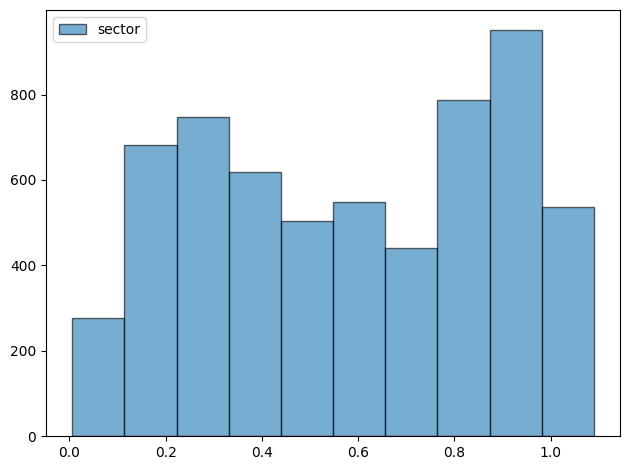

In [537]:
fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)
ax.hist(test_ecl.dist.values,bottom=-0.5,label='sector',alpha=0.6, ec='black')
plt.legend()

In [538]:
test_ecl = test_radec2pix(range(1,12),range(1,5),range(1,5))

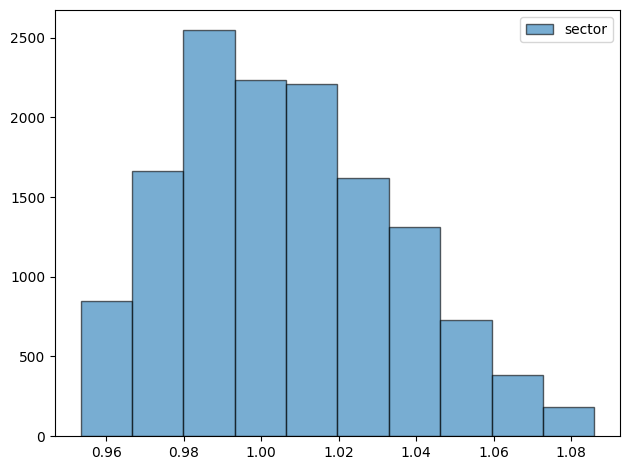

In [539]:
fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)
ax.hist(test_ecl.dist.values,bottom=-0.5,label='sector',alpha=0.6, ec='black')
plt.legend()

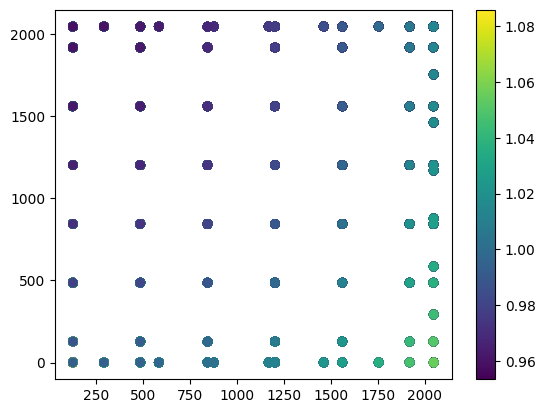

In [540]:

plt.scatter(test_ecl.col.values, test_ecl.row.values,c=test_ecl.dist.values)
plt.colorbar()

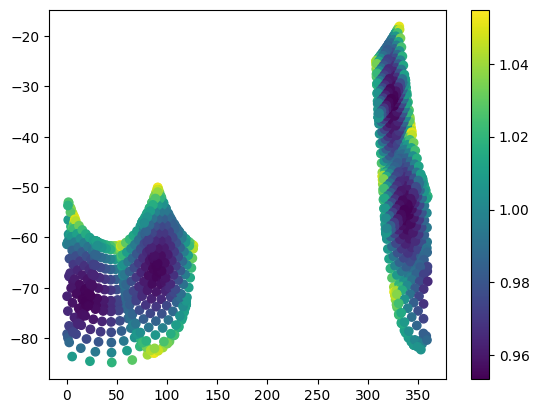

In [541]:
plt.scatter(tests1.ra.values, tests1.dec.values,c=tests1.dist.values)
plt.colorbar()